# Double Factorization with Qubitization-QPE - Resource Estimates

In [1]:
import h5py
import pandas as pd
from qualtran.bloqs.phase_estimation import LPResourceState
import matplotlib.pyplot as plt
from qualtran.resource_counting import get_cost_value, query_costs, QubitCount
from qualtran.drawing import show_bloq
from qualtran.cirq_interop.t_complexity_protocol import TComplexity
from qualtran.resource_counting import QECGatesCost,GateCounts, query_costs


## Utilities

In [2]:
def convert_to_num_label(num):
    if num >= 1000000000000:
        return f"{num / 1000000000000:.1f} Trillion"
    elif num >= 1000000000:
        return f"{num / 1000000000:.1f} Billion"
    elif num >= 1000000:
        return f"{num / 1000000:.1f} Million"
    elif num >= 1000:
        return f"{num / 1000:.1f} K"
    

def convert_to_int(s):
    # Check if the last character is 'k'
    if s[-1].lower() == 'k':
        number = float(s[:-1])
        return int(number * 1000)
    elif s[-1].lower() == 'm':
       number = float(s[:-1])
       return int(number * 1000000)
    elif s[-1].lower() == 'g':
        number = float (s[:-1])
        return int(number * 1000000000)
    elif s[-1].lower() == 't':
        number = float (s[:-1])
        return int(number * 1000000000000)
    else:
        return int(s)
    
def convert_nanoseconds(nanoseconds):
    time_units = [
        ("centuries", 3153600000),
        ("decades", 315360000),
        ("years", 31536000),
        ("days", 86400),
        ("hours", 3600),
        ("mins", 60),
        ("secs", 1),
        ("millisecs", 1e-3),
        ("microsecs", 1e-6),
        ("nanosecs", 1e-9)
    ]
    seconds = nanoseconds * 1e-9  
    for unit, value in time_units:
        if seconds >= value:
            converted_value = seconds / value
            return f"{converted_value:.0f} {unit}"
    
    return f"{nanoseconds} nanosecs"

## Double Factorization with Qubitization-QPE code

In [ ]:
import qualtran.bloqs.chemistry.df.double_factorization as dfmod
from qualtran.bloqs.reflections.reflection_using_prepare import ReflectionUsingPrepare

def _reflect(self):
    return ReflectionUsingPrepare(self.signal_state, global_phase=-1)

for cls_name in ("DoubleFactorizationOneBody", "DoubleFactorizationBlockEncoding"):
    cls = getattr(dfmod, cls_name, None)
    if cls is not None:
        setattr(cls, "reflect", property(_reflect))


In [ ]:
from qualtran.bloqs.chemistry.df.double_factorization import (
    DoubleFactorizationBlockEncoding,
)
from qualtran.bloqs.phase_estimation.qubitization_qpe import QubitizationQPE
from qualtran.resource_counting import BloqCountDictT, SympySymbolAllocator
from qualtran import CtrlSpec

class Mod_QubitizationQPE(QubitizationQPE):
    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> 'BloqCountDictT':
        M = 2**self.m_bits
        return {
            self.ctrl_state_prep: 1,
            self.walk: 1,
            self.walk.reflect.controlled(ctrl_spec=CtrlSpec(cvs=0)): 2 * (self.m_bits - 1),
            self.walk: M - 2 + 1,
            self.qft_inv: 1,
        }

In [5]:
#################### DF-Qubitization-QPE #######################

num_spin_orb = 76 * 2
num_bits_state_prep = 26
num_bits_rot = 23
num_aux = 786
num_eig = num_aux * (num_spin_orb // 2)
ctrl_state_prep = LPResourceState(num_bits_rot)
df_bloq = DoubleFactorizationBlockEncoding(num_spin_orb, num_aux, num_eig, num_bits_state_prep=num_bits_state_prep)
df_bloq_Qubitization_QPE = Mod_QubitizationQPE(df_bloq,ctrl_state_prep)
counts = df_bloq_Qubitization_QPE.t_complexity()



## Resource Estimates

In [6]:
### From Qualtron Documentation    
def get_bloq_logical_counts(bloq):
    from qsharp.estimator import LogicalCounts
    from qualtran._infra.gate_with_registers import get_named_qubits

    num_qubits = bloq.signature.n_qubits()
    complexity = bloq.t_complexity()
    
    return LogicalCounts({
        "numQubits": num_qubits,
        "tCount": complexity.t,
        "rotationCount": complexity.rotations,
    })
    


estimates = get_bloq_logical_counts(df_bloq_Qubitization_QPE).estimate([
    {"errorBudget": 0.01,
    "qubitParams": {"name": "qubit_maj_ns_e6"},
    "qecScheme": {"name": "floquet_code"}}
    # {"qubitParams": {"name": "qubit_gate_ns_e4"}},
    # {"qubitParams": {"name": "qubit_maj_ns_e4"}, "surfaceCode": {"name": "floquet_code"}},
])


total_gates = counts.t + counts.clifford + counts.rotations

data = {
    "Orbitals": num_spin_orb//2,
    "Logical Qubits": [estimates['physicalCountsFormatted']['logicalCountsNumQubits']],
    "T-Gates":  [convert_to_num_label(counts.t)],
    "Logical Gates": [convert_to_num_label(total_gates)],
    "Runtime":[estimates['physicalCountsFormatted']['runtime']]
}

print(data)


{'Orbitals': 76, 'Logical Qubits': ['2.05k'], 'T-Gates': ['2.1 Trillion'], 'Logical Gates': ['2.2 Trillion'], 'Runtime': ['67 days']}


## Results

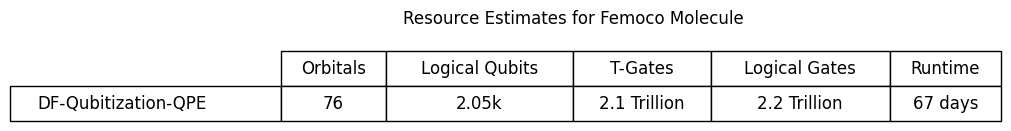

In [20]:

algorithms = ["DF-Qubitization-QPE"]
df = pd.DataFrame(data, index=algorithms)

fig, ax = plt.subplots(figsize=(8, 1))
ax.axis('off')

table = ax.table(
    cellText=df.values,
    rowLabels=df.index,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1], 
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(df.columns) + 1)))
for (row, col), cell in table.get_celld().items():
    cell.set_height(0.3) 

plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.1)

plt.title("Resource Estimates for Femoco Molecule", pad=20)
plt.show()
